# import

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import math
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from  PIL import Image
import os
import random
from tqdm import tqdm
import timm

# 定义参数

In [2]:
INPUT_PATH = '../input/ensemble-1017'
TRAIN_CSV_PATH = '../input/cassava-leaf-disease-classification/train.csv'
TRAIN_IMAGE_PATH = '../input/cassava-leaf-disease-classification/train_images/'
TEST_IMAGE_PATH = '../input/cassava-leaf-disease-classification/test_images/'
SUBMISSION_PATH = 'submission.csv'
DEVICES = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
OUT_FEATURES = 5
NUM_EPOCHS = 17
BATCH_SIZE = 32
IMAGE_SIZE = 224
OPTIMIZER = torch.optim.AdamW
SEED = 42
LR_START = 1e-5
LR_MAX = 2e-4
LR_FINAL = 1e-5
TTA = 3

# tr1.损失函数
1st solution's loss
1. B4: Sigmoid Focal Cross Entropy Loss: is good for class imbalance problems / label smoothing
2. ResNeXt50: Cross Entropy Loss

In [3]:
def sigmoid_focal_cross_entropy(y_hat, y_true, alpha=0.25, gamma=2.0):
    # label smoothing
    def smooth(y, smooth_factor):
        assert  len(y.shape) == 2
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
        return y

    smooth_factor = 0.1

    if not isinstance(y_true, torch.Tensor):
        y_true = torch.tensor(y_true)
    if not isinstance(y_hat, torch.Tensor):
        y_hat = torch.tensor(y_hat)

    y_true = smooth(y_true, smooth_factor)

    cross_entropy = F.binary_cross_entropy_with_logits(y_hat, y_true, reduction='none')
    p_t = y_true * y_hat + (1 - y_true) * (1 - y_hat)
    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
    modulating_factor = (1.0 - p_t).pow(gamma)

    return torch.sum(alpha_t * modulating_factor * cross_entropy, dim=-1)

# tr2.learning_rate

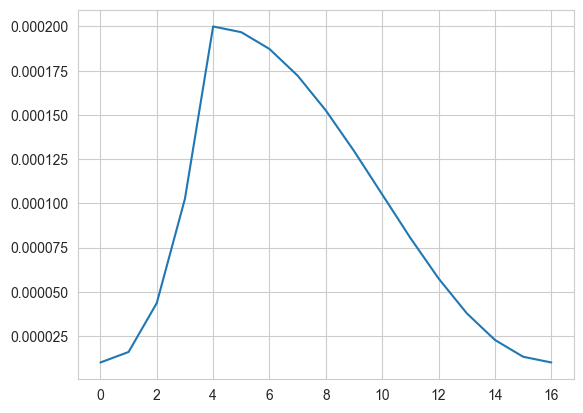

In [4]:
def lr_tune(epoch, num_epochs=NUM_EPOCHS):
    lr_start = LR_START
    lr_max = LR_MAX
    lr_final = LR_FINAL
    lr_warmup_epoch = 4
    lr_sustain_epoch = 0
    lr_decay_epoch = num_epochs - lr_warmup_epoch - lr_sustain_epoch - 1

    if epoch <= lr_warmup_epoch:
        lr = lr_start + (lr_max - lr_start) * (epoch / lr_warmup_epoch) ** 2.5
    elif epoch < lr_warmup_epoch + lr_sustain_epoch:
        lr = lr_max
    else:
        epoch_diff = epoch - lr_warmup_epoch - lr_sustain_epoch
        decay_factor = (epoch_diff / lr_decay_epoch) * math.pi
        decay_factor = (torch.cos(torch.tensor(decay_factor)).numpy() + 1) / 2
        lr = lr_final + (lr_max - lr_final) * decay_factor
    return lr
x = [i for i in range(NUM_EPOCHS)]
y = [lr_tune(i) for i in x]
plt.plot(x, y)

# tr3.albumentations

In [5]:
train_augs = A.Compose(
    [
        A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        A.CoarseDropout(p=0.5),
        A.Cutout(p=0.5),
        ToTensorV2(p=1.0)
    ], p=1.0)
valid_augs = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.CenterCrop(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(
             mean=[0.485, 0.456, 0.406],
             std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ]
)

C:\Users\33143\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\augmentations\dropout\cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# tr4.TTA

In [6]:
test_augs = A.Compose([
    A.OneOf([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
        A.CenterCrop(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
        A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, p=1.0)
    ], p=1.0),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0)
    ], p=1.0
)

# tr5.seed

In [7]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
seed_everything(SEED)

# 定义数据集

# 定义模型

In [9]:
model_name1 = "resnext50_32x4d"  # ns 表示 noisy student
my_model_1 = timm.create_model(model_name1, pretrained=False)
my_model_1.fc = nn.Linear(my_model_1.fc.in_features, OUT_FEATURES)
nn.init.xavier_uniform_(my_model_1.fc.weight)
if my_model_1.fc.bias is not None:
    nn.init.zeros_(my_model_1.fc.bias)
my_model_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [10]:
model_name2 = "tf_efficientnet_b4_ns"  # ns 表示 noisy student
my_model_2 = timm.create_model(model_name2, pretrained=False)
my_model_2.classifier = nn.Linear(my_model_2.classifier.in_features, OUT_FEATURES)
nn.init.xavier_uniform_(my_model_2.classifier.weight)
if my_model_2.classifier.bias is not None:
    nn.init.zeros_(my_model_2.classifier.bias)
my_model_2

C:\Users\33143\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

# 定义训练

# 训练

In [ ]:
torch.cuda.empty_cache()

# 验证

In [ ]:
preds_1 = []
my_model_1.eval()
model_param = torch.load(os.path.join(INPUT_PATH, 'best_model_res50.pth'))
new_model_param = {k[7:]: v for k, v in model_param.items() if 'module.' in k}
my_model_1.load_state_dict(new_model_param)
my_model_1 = nn.DataParallel(my_model_1)
test_image_list = np.asarray([image_name for image_name in os.listdir(TEST_IMAGE_PATH)])
for single_image_name in test_image_list:
    with torch.no_grad():
        ans = torch.zeros(5).cuda()
        for _ in range(TTA):
            image = Image.open(os.path.join(TEST_IMAGE_PATH, single_image_name))
            aug_image = test_augs(image=np.array(image))['image']
            test_image = torch.tensor(aug_image, dtype=torch.float).unsqueeze(0).cuda()
            ans += my_model_1(test_image).view(ans.shape)
        preds_1.append(ans)
predictions_1 = torch.tensor(preds_1, dtype=torch.float)
normalize_pred_1 = F.normalize(preds_1.T, p=2, dim=0).T
normalize_pred_1 = normalize_pred_1.cpu()
torch.cuda.empty_cache()

preds_2 = []
my_model_2.eval()
model_param = torch.load(os.path.join(INPUT_PATH, 'best_model_bs4ns.pth'))
new_model_param = {k[7:]: v for k, v in model_param.items() if 'module.' in k}
my_model_2.load_state_dict(new_model_param)
my_model_2 = nn.DataParallel(my_model_2)
test_image_list = np.asarray([image_name for image_name in os.listdir(TEST_IMAGE_PATH)])
for single_image_name in test_image_list:
    with torch.no_grad():
        ans = torch.zeros(5).cuda()
        for _ in range(TTA):
            image = Image.open(os.path.join(TEST_IMAGE_PATH, single_image_name))
            aug_image = test_augs(image=np.array(image))['image']
            test_image = torch.tensor(aug_image, dtype=torch.float).unsqueeze(0).cuda()
            ans += my_model_2(test_image).view(ans.shape)
        preds_2.append(ans)
predictions_2 = torch.tensor(preds_2, dtype=torch.float)
normalize_pred_2 = F.normalize(preds_2.T, p=2, dim=0).T
normalize_pred_2 = normalize_pred_2.cpu()

final_pred = normalize_pred_1 + normalize_pred_2


label = final_pred.argmax(dim=-1).numpy()
df_submission = pd.DataFrame(columns=pd.read_csv(TRAIN_CSV_PATH).columns)
df_submission['image_id'] = pd.DataFrame(test_image_list)
df_submission['label'] = pd.DataFrame(label)
df_submission.to_csv(SUBMISSION_PATH, index=False)